<a href="https://www.kaggle.com/code/ibrahimnibrahim/brain-cancer-mri-98-test-accuracy?scriptVersionId=244240262" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, models

2025-06-07 14:58:40.641212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749308320.851354      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749308320.910610      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
FOLDER='/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer/'

In [3]:
train,test= tf.keras.utils.image_dataset_from_directory(
    directory=FOLDER,            
    label_mode='categorical',        
    image_size=(224, 224),  
    validation_split=0.2,
    subset='both',
    seed=123,
    batch_size=64                    
)


class_names=train.class_names

Found 6056 files belonging to 3 classes.
Using 4845 files for training.
Using 1211 files for validation.


I0000 00:00:1749308342.285188      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
train=train.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(buffer_size=1000)
test=test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
base_model = EfficientNetB3(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False    
)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)        
x = base_model(x, training=False)        
x = layers.GlobalAveragePooling2D()(x)    
x = layers.Dense(512, activation='relu')(x)  
x = layers.Dense(3, activation='softmax')(x) 

final_model = models.Model(inputs=inputs, outputs=x)

final_model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         786,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,572,018 (44.14 MB)

 Trainable params: 11,484,715 (43.81 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [6]:
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,  
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    min_lr=1e-7
)


class StopOnValAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target=0.985):
        super().__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target:
            print(f"\nReached {val_acc:.2%} val_accuracy — stopping training.")
            self.model.stop_training = True

In [8]:
history = final_model.fit(
    train,
    validation_data=test,
    epochs=100,
    callbacks=[early_stopping, reduce_lr,StopOnValAccuracy(target=0.980)]
)

Epoch 1/100


E0000 00:00:1749308434.031024      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1749308453.728250      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


76/76 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.8309 - loss: 0.3958 - val_accuracy: 0.8373 - val_loss: 0.8034 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 69s 913ms/step - accuracy: 0.9661 - loss: 0.1073 - val_accuracy: 0.8902 - val_loss: 0.5027 - learning_rate: 0.0010
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 69s 907ms/step - accuracy: 0.9649 - loss: 0.1063 - val_accuracy: 0.7581 - val_loss: 1.3279 - learning_rate: 0.0010
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 70s 918ms/step - accuracy: 0.9733 - loss: 0.0703 - val_accuracy: 0.9240 - val_loss: 0.3416 - learning_rate: 0.0010
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 69s 914ms/step - accuracy: 0.9836 - loss: 0.0432 - val_accuracy: 0.9769 - val_loss: 0.0695 - learning_rate: 0.0010
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 68s 897ms/step - accuracy: 0.9800 - loss: 0.0489 - val_accuracy: 0.8704 - val_loss: 0.5020 - learning_rate: 0.0010
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 68s 897ms/step - accuracy: 0.9861 - loss: 0.0388 - 

In [9]:
final_model.evaluate(test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9799 - loss: 0.0441


[0.04945629462599754, 0.9826589822769165]

In [10]:
y_true = []
y_pred_probs = []

for images, labels in test:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(final_model.predict(images, verbose=0))

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Check if labels are one-hot encoded
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

brain_glioma     0.9871    0.9897    0.9884       387
 brain_menin     0.9900    0.9611    0.9753       411
 brain_tumor     0.9717    0.9976    0.9845       413

    accuracy                         0.9827      1211
   macro avg     0.9829    0.9828    0.9827      1211
weighted avg     0.9828    0.9827    0.9826      1211



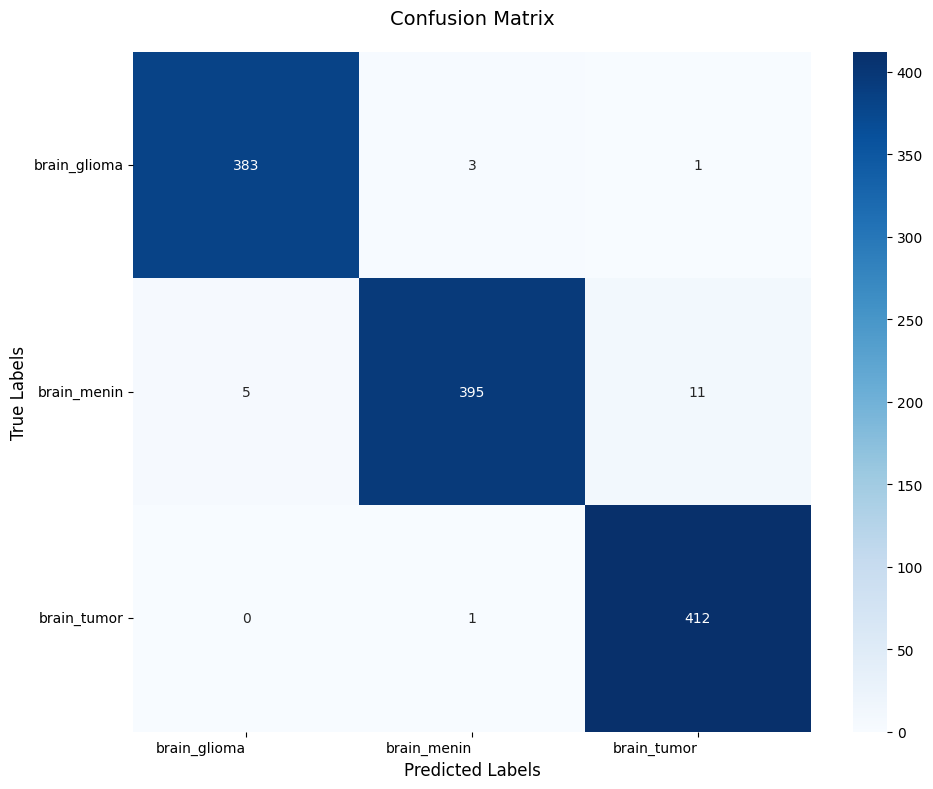

In [11]:
# 1. Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test:
    # Get true labels (convert from one-hot if needed)
    if len(labels.shape) > 1:  # If one-hot encoded
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    else:
        y_true.extend(labels.numpy())
    
    # Get predictions
    preds = final_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Create figure
plt.figure(figsize=(10, 8))

# 4. Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names)

# 5. Add labels and title
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, pad=20)

# 6. Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='right')
plt.yticks(rotation=0)

# 7. Adjust layout
plt.tight_layout()
plt.show()

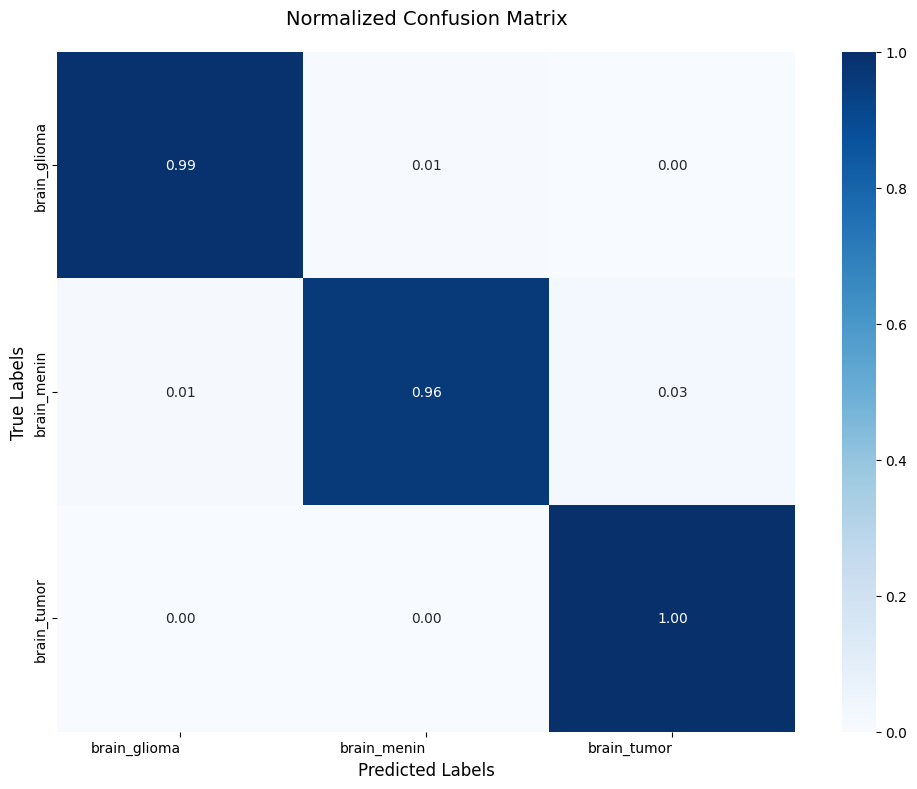

In [12]:
# 1. Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test:
    # Get true labels (convert from one-hot if needed)
    if len(labels.shape) > 1:  # If one-hot encoded
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    else:
        y_true.extend(labels.numpy())
    
    # Get predictions
    preds = final_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Compute confusion matrix and normalize it
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Create figure
plt.figure(figsize=(10, 8))

# 4. Create heatmap with normalized values
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, 
            yticklabels=class_names,
            vmin=0, vmax=1)

# 5. Add labels and title
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Normalized Confusion Matrix', fontsize=14, pad=20)

# 6. Rotate x-axis labels for better readability
plt.xticks(rotation=0, ha='right')

# 7. Adjust layout
plt.tight_layout()
plt.show()

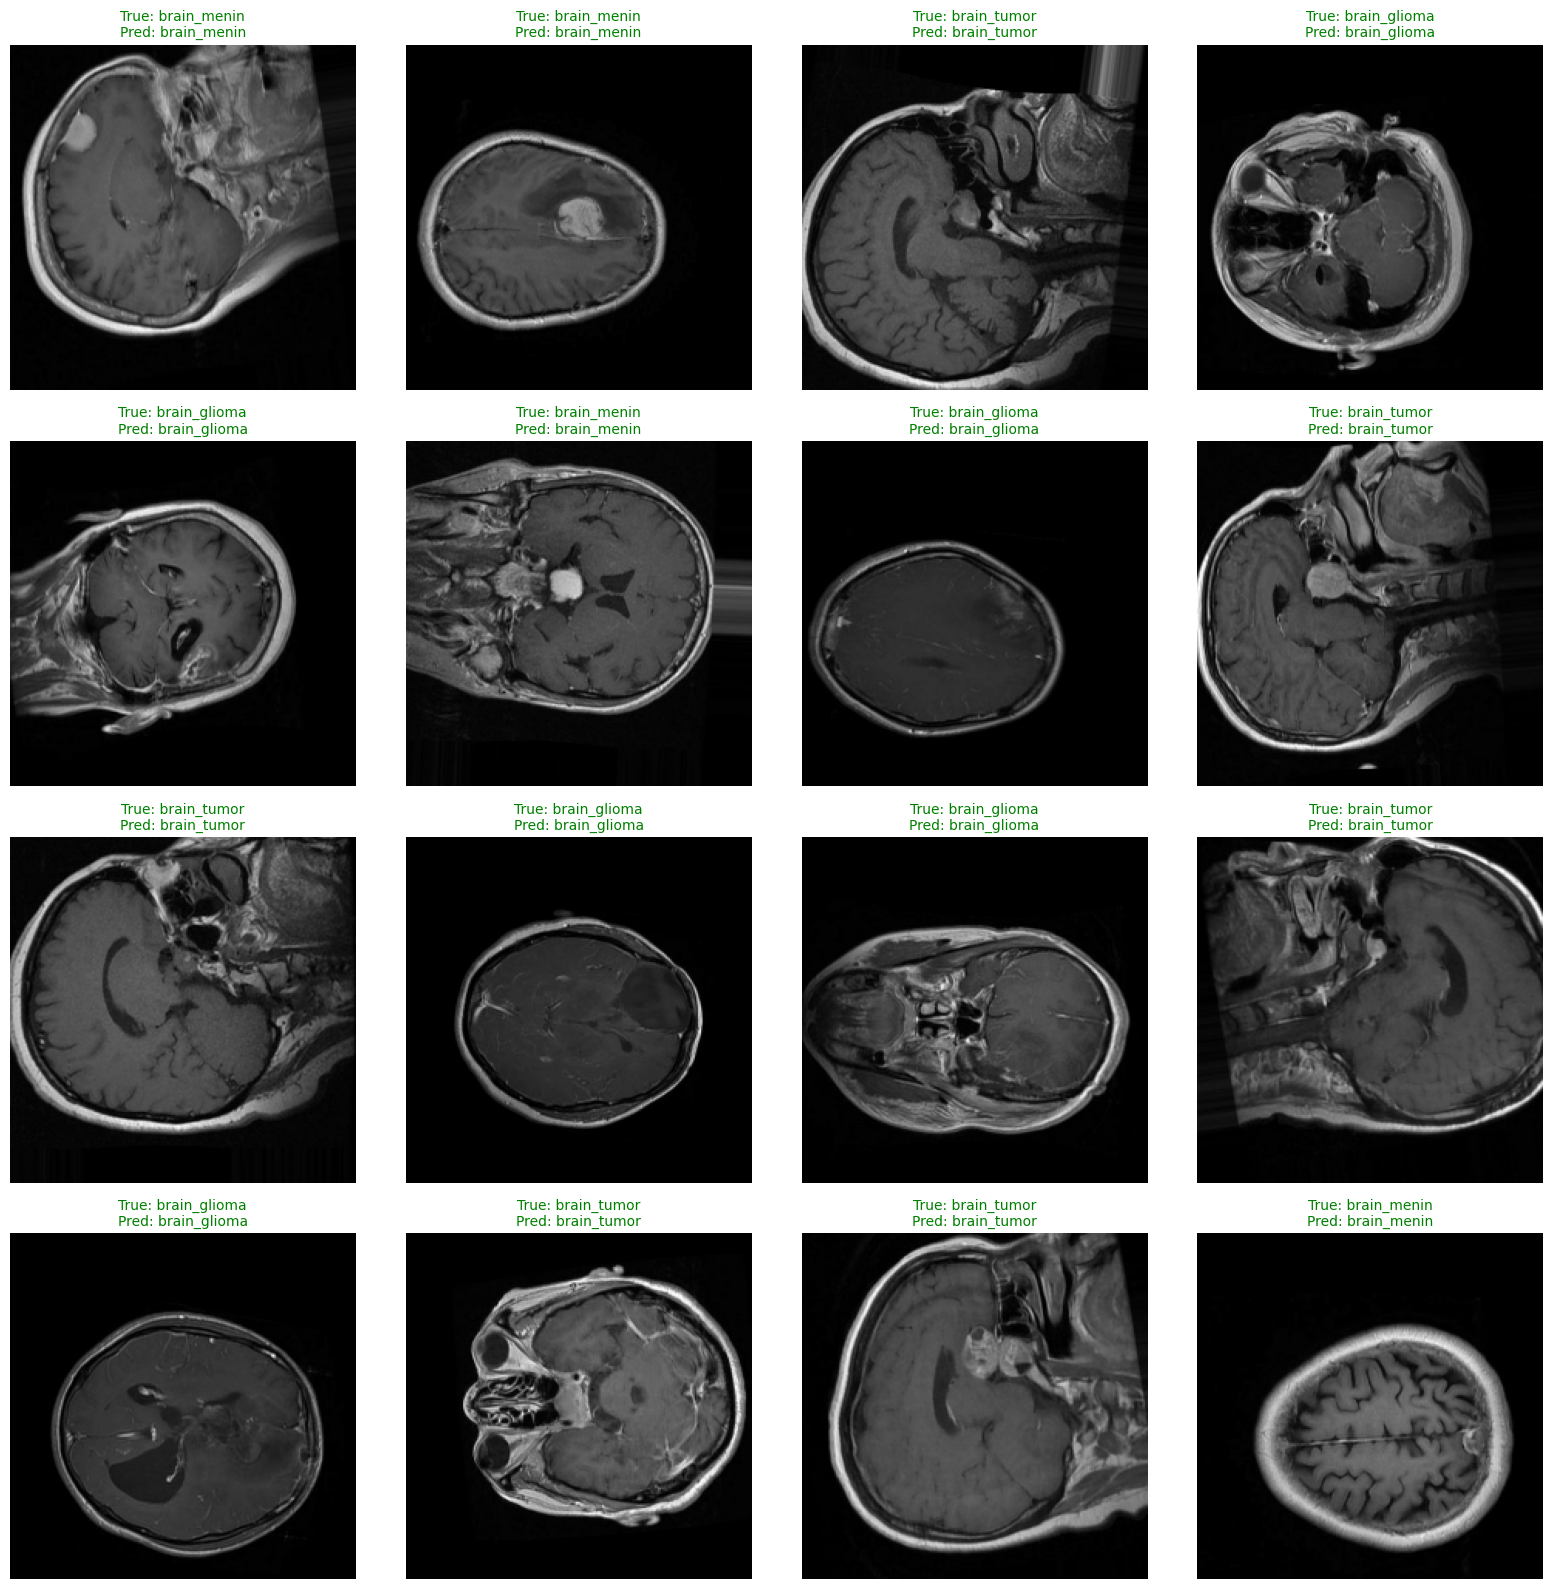

In [13]:
def plot_predictions(model, dataset, class_names, num_images=16):
    """
    Plots images with their true and predicted labels in a 4x4 grid
    
    Args:
        model: Trained Keras model
        dataset: TensorFlow dataset (batched)
        class_names: List of class names
        num_images: Number of images to display (default 16)
    """
    plt.figure(figsize=(16, 16))  # Increased figure size for better visibility
    
    # Take one batch from the dataset
    for images, labels in dataset.take(1):
        # Make predictions
        preds = model.predict(images, verbose=0)
        pred_classes = np.argmax(preds, axis=1)
        
        # Convert one-hot labels if needed
        if len(labels.shape) > 1:
            true_classes = np.argmax(labels.numpy(), axis=1)
        else:
            true_classes = labels.numpy()
        
        # Plot images in 4x4 grid
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(4, 4, i+1)  # Changed to 4 rows, 4 columns
            plt.imshow(images[i].numpy().astype("uint8"))
            
            # Set title with color coding
            true_label = class_names[true_classes[i]]
            pred_label = class_names[pred_classes[i]]
            
            color = 'green' if true_label == pred_label else 'red'
            plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Usage
plot_predictions(final_model, test, class_names)